In [10]:
import sys
sys.path.append('../')

In [11]:
import costing
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
pd.set_option("display.precision", 5)
pd.set_option('display.max_columns', None)

plt.style.use('ggplot')

import warnings 
warnings.filterwarnings('ignore')

In [12]:
tools_old = pd.read_csv('../data/tools.csv')
requests_old = pd.read_csv('../data/requests.csv')
delivers_old = pd.read_csv('../data/delivers.csv')
(tools_old.shape, requests_old.shape, delivers_old.shape)

((40457, 12), (70865, 5), (53619, 8))

In [17]:
# dataset = pd.read_csv('../data/dataset.csv')
# fpmms = pd.read_csv('../data/fpmms.csv')
tools = pd.read_csv('../data/tools_2/tools.csv')
requests = pd.read_csv('../data/tools_2/requests.csv')
delivers = pd.read_csv('../data/tools_2/delivers.csv')

In [18]:
tools.shape, requests.shape, delivers.shape

((36062, 13), (95301, 5), (37824, 9))

In [7]:
requests.columns, requests.shape

(Index(['request_id', 'request_block', 'prompt_request', 'tool', 'nonce'], dtype='object'),
 (95301, 5))

In [8]:
delivers.columns, delivers.shape

(Index(['request_id', 'deliver_block', 'prompt_response', 'p_yes', 'p_no',
        'confidence', 'info_utility', 'vote', 'win_probability'],
       dtype='object'),
 (37824, 9))

In [9]:
# add full_prompt to dataset
include_tools = [
    'prediction-offline',
    'prediction-online',
    'prediction-online-summarized-info',
    'prediction-offline-sme',
    'prediction-online-sme',
    'claude-prediction-online',
    'claude-prediction-offline'
]

tools = tools[tools.tool.isin(include_tools)]

In [10]:
tools.shape

(35869, 13)

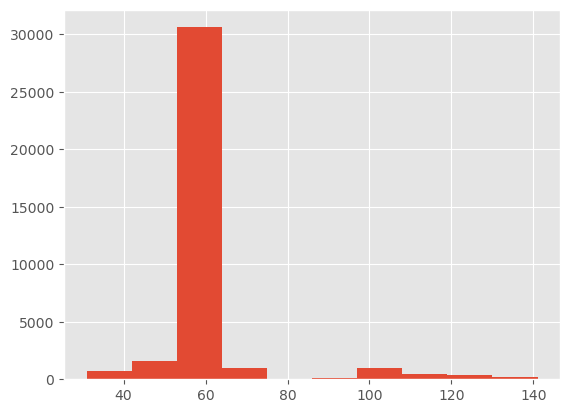

In [11]:
tools['prompt_request'].apply(lambda x: len(x.split(' '))).hist()

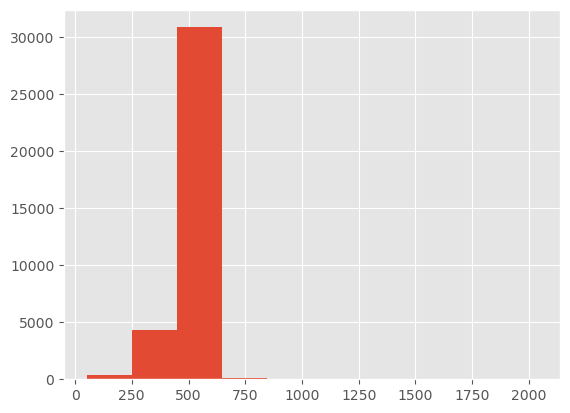

In [12]:
tools['prompt_response'].apply(lambda x: len(x.split(' '))).hist()

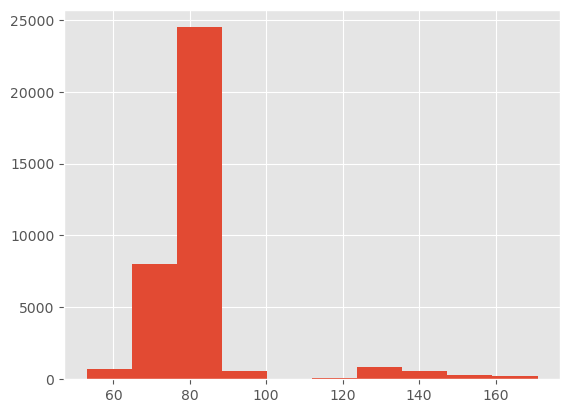

In [13]:
tools['prompt_request_token'] = tools['prompt_request'].apply(lambda x: costing.TokenCounter.count_tokens(x, model='gpt-3.5-turbo'))
tools['prompt_request'].apply(lambda x: costing.TokenCounter.count_tokens(x, model='gpt-3.5-turbo')).hist()

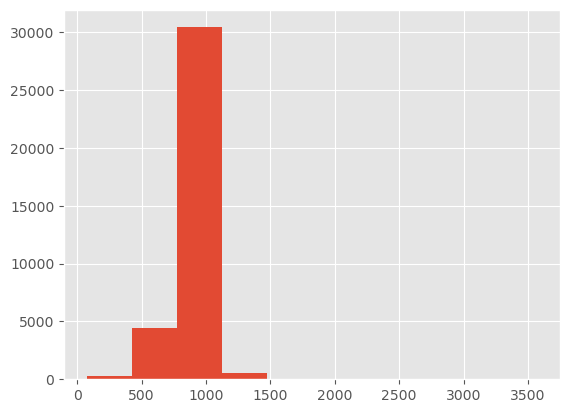

In [14]:
tools['prompt_response_token'] = tools['prompt_response'].apply(lambda x: costing.TokenCounter.count_tokens(x, model='gpt-3.5-turbo'))
tools['prompt_response'].apply(lambda x: costing.TokenCounter.count_tokens(x, model='gpt-3.5-turbo')).hist()

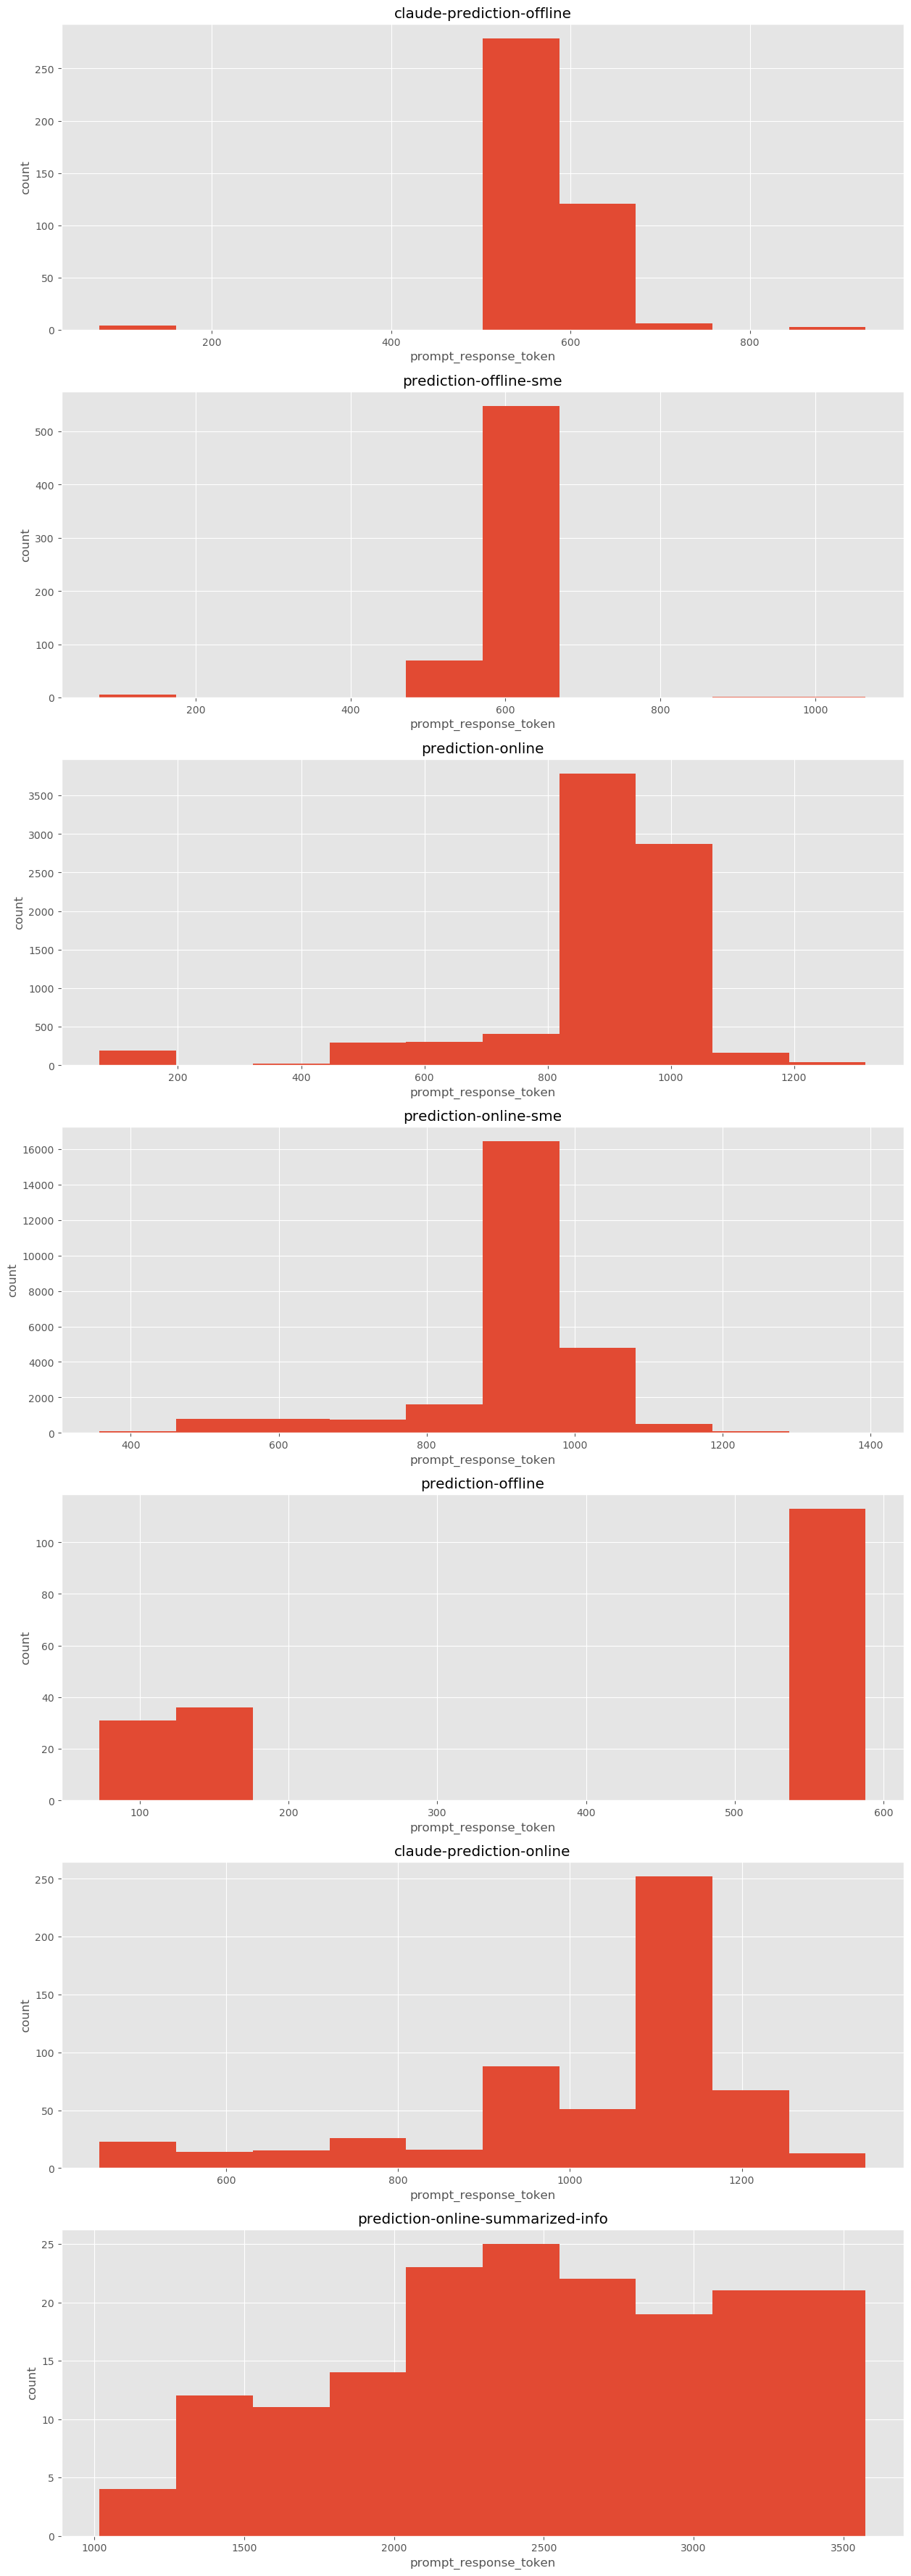

In [15]:
# subplots for full_prompt_token by tool

fig, axes = plt.subplots(7, 1, figsize=(15, 45))

for i, tool in enumerate(tools['tool'].unique()):
    tools[tools['tool'] == tool]['prompt_response_token'].hist(ax=axes[i])
    axes[i].set_title(tool)
    axes[i].set_xlabel('prompt_response_token')
    axes[i].set_ylabel('count')

In [16]:
tools.groupby('tool')['prompt_response_token'].mean().sort_values(ascending=False)

tool
prediction-online-summarized-info    2501.93023
claude-prediction-online             1025.07257
prediction-online-sme                 916.45204
prediction-online                     887.51860
claude-prediction-offline             591.58838
prediction-offline-sme                586.10224
prediction-offline                    398.88333
Name: prompt_response_token, dtype: float64

In [17]:
tools.tool.value_counts()

tool
prediction-online-sme                25847
prediction-online                     8066
prediction-offline-sme                 626
claude-prediction-online               565
claude-prediction-offline              413
prediction-offline                     180
prediction-online-summarized-info      172
Name: count, dtype: int64

In [18]:
for data in tqdm(tools.iterrows(), total=len(tools), desc='Counting costs'):
    tool = data[1].tool
    prompt = data[1].prompt_response
    response = None
    counter = costing.CostCounter(tool=tool, prediciton_prompt=prompt, final_response=response)
    cost = counter.run()
    tools.loc[data[0], 'cost'] = cost
    tools.loc[data[0], 'input_tokens'] = counter.total_input_tokens
    tools.loc[data[0], 'output_tokens'] = counter.total_output_tokens

Counting costs: 100%|██████████| 35869/35869 [01:27<00:00, 409.58it/s]


In [19]:
print(f"Min cost: {tools.cost.min():.5f}")
print(f"Max cost: {tools.cost.max():.5f}")
print(f"Mean cost: {tools.cost.mean():.5f}")
print(f"Median cost: {tools.cost.median():.5f}")

Min cost: 0.00027
Max cost: 0.05557
Mean cost: 0.02819
Median cost: 0.02909


In [27]:
tools.groupby('tool').cost.aggregate([
    'min', 'max', 'mean', 'median',
    lambda x: np.percentile(x, 75), 
    lambda x: np.percentile(x, 90)
]).rename(columns={
    '<lambda_0>': '75th percentile',
    '<lambda_1>': '90th percentile'
}).sort_values(by='90th percentile', ascending=False)

,min,max,mean,median,75th percentile,90th percentile
tool,,,,,,
claude-prediction-online,0.04032,0.05557,0.04982,0.05106,0.05178,0.05236
prediction-online-summarized-info,0.02775,0.03287,0.03072,0.03072,0.03183,0.03241
prediction-online-sme,0.02740,0.03051,0.02908,0.02914,0.02924,0.02937
prediction-online,0.02587,0.02835,0.02749,0.02758,0.02764,0.02772
claude-prediction-offline,0.00301,0.01030,0.00748,0.00740,0.00768,0.00774
prediction-offline-sme,0.00096,0.00294,0.00198,0.00196,0.00198,0.00209
prediction-offline,0.00027,0.00079,0.00060,0.00076,0.00077,0.00078


In [28]:
tools.groupby('tool').input_tokens.aggregate([
    'min', 'max', 'mean', 'median',
    lambda x: np.percentile(x, 75), 
    lambda x: np.percentile(x, 90)
]).rename(columns={
    '<lambda_0>': '75th percentile',
    '<lambda_1>': '90th percentile'
}).sort_values(by='90th percentile', ascending=False)

,min,max,mean,median,75th percentile,90th percentile
tool,,,,,,
prediction-online-summarized-info,2353.0,7467.0,5322.86047,5324.0,6433.5,7006.6
prediction-online-sme,1802.0,4907.0,3477.35613,3539.0,3638.0,3767.0
claude-prediction-online,1315.0,3221.0,2502.13805,2657.0,2747.0,2820.2
prediction-online,466.0,2951.0,2094.06025,2177.0,2241.0,2323.0
prediction-offline-sme,562.0,2539.0,1581.21406,1563.0,1583.0,1689.0
claude-prediction-offline,76.0,987.0,634.63196,625.0,660.0,667.0
prediction-offline,73.0,588.0,398.88333,558.0,573.0,577.0


In [29]:
tools.groupby('tool').output_tokens.aggregate([
    'min', 'max', 'mean', 'median',
    lambda x: np.percentile(x, 75), 
    lambda x: np.percentile(x, 90)
]).rename(columns={
    '<lambda_0>': '75th percentile',
    '<lambda_1>': '90th percentile'
}).sort_values(by='90th percentile', ascending=False)

,min,max,mean,median,75th percentile,90th percentile
tool,,,,,,
prediction-online-sme,300.0,300.0,300.0,300.0,300.0,300.0
claude-prediction-online,200.0,200.0,200.0,200.0,200.0,200.0
prediction-offline-sme,200.0,200.0,200.0,200.0,200.0,200.0
prediction-online,200.0,200.0,200.0,200.0,200.0,200.0
prediction-online-summarized-info,200.0,200.0,200.0,200.0,200.0,200.0
claude-prediction-offline,100.0,100.0,100.0,100.0,100.0,100.0
prediction-offline,100.0,100.0,100.0,100.0,100.0,100.0


In [30]:
tools.tool.value_counts()

tool
prediction-online-sme                25847
prediction-online                     8066
prediction-offline-sme                 626
claude-prediction-online               565
claude-prediction-offline              413
prediction-offline                     180
prediction-online-summarized-info      172
Name: count, dtype: int64

In [31]:
tools_old.tool.value_counts()

tool
prediction-online-sme                         22076
prediction-online                             13853
prediction-offline-sme                         1231
prediction-offline                             1114
claude-prediction-online                       1055
claude-prediction-offline                       943
prediction-online-summarized-info               177
prediction-sentence-embedding-bold                6
prediction-sentence-embedding-conservative        2
Name: count, dtype: int64